#TP 4 DE BIG DATA SOBRE MÉTODOS SUPERVISADOS: REGRESIÓN &  CLASIFICACIÓN USANDO LA EHP

#A.
Enfoque de validación  
Utilicen la base respondieron. Para cada año, dividan las observaciones en
una base de prueba (test) y una de entrenamiento (train) utilizando el
comando train_test_split. La base de entrenamiento debe comprender el
70% de los datos, y la semilla a utilizar (random state instance) debe ser 444.
Establezca a desocupado como su variable dependiente en la base de
entrenamiento (vector y). El resto de las variables seleccionadas serán las
variables independientes (matriz X). Recuerden agregar la columna de unos
(1).

In [73]:
import pandas as pd
import numpy as np
import os
import random
#Para crear datos con distribucion normal en otro modulo
from scipy.stats import norm
#Importo matplotlib.pyplot
import matplotlib.pyplot as plt
#Importamos los paquetes para usar kernels
from sklearn.neighbors import KernelDensity
#Instalamos seaborn
!pip install seaborn
import seaborn as sns
#Importamos estos paquetes para usar kernels jerarquicos y dendogramas
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
#Importamos los paquetes para testear y entrenar nuestra data,vecinos cercanos y regresión, mas unos cuantos mas que no sirven para este TP.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

#Cargamos nuestra base de datos del 2024
url = "https://github.com/RoccoGabrielPimenta/BigDataUBA-Grupo22/raw/refs/heads/main/TP%202/usu_individual_T124.xlsx"
df = pd.read_excel(url)
df.head(5)
pd.set_option('display.max_columns', 6)

#Cargamos nuestra base de datos del 2004
url = "https://github.com/RoccoGabrielPimenta/BigDataUBA-Grupo22/raw/refs/heads/main/TP%202/usu_individual_t104.dta"
df2 = pd.read_stata(url)


In [74]:
#lo primero que hacemos es tomar los datos de la region patagonica del año 2004. Para eso filtramos el inclullendo solo aquellas regiones que responden a la patagonia.
#Luego, tomamos los datos de la region patagonica del año 2024. Para eso filtramos el inclullendo solo aquellas regiones que responden al numero 42.
#Para concluir,juantamos las distitas que responden a esta region.
df2[df2["region"]=='Patagónica']
df3 = df[df["REGION"]==42]
df3
df4 = df2[df2["region"]=="Patagónica"]
df4.columns = df4.columns.str.upper()
df4
df_completo = pd.concat([df3,df4],axis=0)
#Indicamos cuáles de esas columnas vamos a estar utilizando
columnas_a_usar = [1,11,13,14,16,19,20,21,27,44,45,132]
columnas_a_usar1 = [27]

#filtramos las columnas que queremos en un nuevo dataset
df_filtrado_24 = df_completo.iloc[0:4513, columnas_a_usar]
df_filtrado_04 = df_completo.iloc[4513:7777, columnas_a_usar]

#filtramos para tener los datos de los dos años en una sola base de datos
df8 = df_filtrado_04
df8["CH04"] = df8["CH04"].replace({'Varón':1, 'Mujer':2})
df8["CH06"] = df8["CH06"].replace({'Menos de 1 año':0, '98 y más años':98})
df8["CH07"] = df8["CH07"].replace({'Unido':1, 'Casado':2, 'Separado o divorciado':3, 'Viudo':4, 'Soltero':5})
df8["CH09"] = df8["CH09"].replace({'Sí':1, 'No':2, 'Menor de 2 años':3})
df8['ESTADO'] = df8['ESTADO'].replace({
    'Ocupado': 1,
    'Desocupado': 2,
    'Inactivo': 3,
    "Menor de 10 años" : 4
})
df8["CH12"] = df8["CH12"].replace({"Jardín/Preescolar":0, "Primario":6, "EGB":9, "Secundario":12, "Polimodal":12, "Terciario":18, "Universitario":18, "Posgrado Universitario":24, "Educación especial (discapacitado)":0})
df8["CH13"] = df8["CH13"].replace({"Sí":0, "No":-1, "Ns./Nr.":0})
df8["CH14"] = df8["CH14"].replace({"Ninguno":6, "Primero":5, "Segundo":4, "Tercero":3, "Cuarto":2, "Quinto":1, "Sexto":6, "Séptimo":7, "Octavo":8, "Noveno":9,"Educación especial":0,"Ns/Nr":0})
df8
df9 = df_filtrado_24
df9["CH12"] = df9["CH12"].replace({0:0, 2:6, 3:9, 4:12, 5:12, 6:18, 7:18,8:24, 9:0})
df9["CH13"] = df9["CH13"].replace({0:0, 1.0:-1, 9:0})
df9["CH14"] = df9["CH14"].replace({0:6, 1:5, 2:4,3:3, 4:2, 5:1, 6:6, 7:7,8:8, 9:9, 98:0, 99:0})

#Limpiamos los datos que no nos interesan y definimos una versión final para la base de datos
ultimo_df = pd.concat([df8, df9],axis=0)
ultimo_df = ultimo_df.replace("NaN", 0)
ultimo_df = ultimo_df.replace([np.nan, -np.inf], 0)
ultimo_df = ultimo_df.apply(pd.to_numeric, errors='coerce').fillna(0)
ultimo_df['CH13'] = ultimo_df['CH13'].replace(2, -1)
ultimo_df.loc[ultimo_df['CH13'] < 3, 'CH13'] = 0

pd.set_option("display.max_rows", 8)

ultimo_df

<ipython-input-74-9f4f3215bce1>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df8["CH04"] = df8["CH04"].replace({'Varón':1, 'Mujer':2})
<ipython-input-74-9f4f3215bce1>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df8["CH06"] = df8["CH06"].replace({'Menos de 1 año':0, '98 y más años':98})
<ipython-input-74-9f4f3215bce1>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

,ANO4,CH04,CH06,...,PP3E_TOT,PP3F_TOT,P21
42025,2004.0,1,34.0,...,36.0,0.0,1000.0
42026,2004.0,1,62.0,...,0.0,0.0,1200.0
42027,2004.0,2,58.0,...,0.0,0.0,0.0
42028,2004.0,1,38.0,...,48.0,0.0,1200.0
...,...,...,...,...,...,...,...
45932,2024.0,2,34.0,...,30.0,0.0,160000.0
45933,2024.0,1,10.0,...,0.0,0.0,0.0
45934,2024.0,2,8.0,...,0.0,0.0,0.0
45935,2024.0,1,6.0,...,0.0,0.0,0.0


In [75]:
#Creo la variable que contiene la edad de los encuestados
edad=ultimo_df[["CH06"]]

In [76]:
#Creamos una variable con los datos que vamos a estar usando que son edad estado de desocupacion y el año
edad2 = (ultimo_df[["CH06", "ESTADO","ANO4"]])

In [77]:
#1ro tomamos la columnas que nos interesan para hacer la variable.
#tomamos los datos CH12 y los remplazamos por el numero de años que equivalen cada nivel de educacion. los datos de CH13 los cambiamos por un 0 en caso de ser 1 y -1 en caso de que no halla terminado.En CH14 le restamos a 6 el ultimo año que curso, exeptuando a los EGB.
educ=(ultimo_df[["CH12", "CH13","CH14"]])
educ
pd.set_option('display.max_rows', 8)
#creamos una variable en bace a esta relacion:
EDUC = educ["CH12"]+educ["CH13"]*educ["CH14"]
EDUC

,0
42025,12.0
42026,6.0
42027,6.0
42028,12.0
...,...
45932,12.0
45933,6.0
45934,6.0
45935,6.0


In [78]:
#inflacion entre el 2004 y el 2024 es un 46.137,21%
salario_semanal=(ultimo_df["P21"])

salario_semana04 = salario_semanal.iloc[0:4513]*11.53 #siendo este numero 461.37/40
salario_semana24 = salario_semanal.iloc[4513:7777]/40

salario_semanal  = pd.concat([salario_semana04, salario_semana24],axis=0)
df = salario_semanal[salario_semanal != 0]


In [79]:
#Defino una variable que contiene el estado civil de la persona
estado_civil = ultimo_df[["CH07"]]

In [80]:
alfabeto=ultimo_df[["CH09"]]

In [81]:
genero=ultimo_df[["CH04"]]
femenino=ultimo_df[["CH04"]].iloc[2]

In [82]:
#Dividimos la data entre los que respindieron y no respondieron
respondieron = ultimo_df.query("ESTADO != 0")
norespondieron = ultimo_df.query("ESTADO == 0")

In [83]:
#Definimos ocupados y desocupados
ocupados = ultimo_df[ultimo_df['ESTADO'] == 1]
desocupados = ultimo_df[ultimo_df['ESTADO'] == 2]

In [84]:
#Le damos labels a las dos variables
ocupados['label'] = 1
desocupados['label'] = 2

#Unimos los dataframes para que no nos de error a la hora de hacer el testeo y entrenamiento
estados_unidos = pd.concat([ocupados, desocupados])

#Separamos los datos con X e Y para utilizalos mas facilmente en la función train_test_splint
X = estados_unidos.drop(columns=['label'])
y = estados_unidos['label']

<ipython-input-84-e956e82c441e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocupados['label'] = 1
<ipython-input-84-e956e82c441e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desocupados['label'] = 2


In [85]:
#La variable "P21" que utilizamos para el salario estaba causando una prediccion perfecta en el punto 5, con una matriz de correlacion se pudo hallar el problema
y = estados_unidos['P21']
X = estados_unidos.drop(columns=['P21'])

In [86]:
#Usamos la train_test_split para hacer nuestro entrenamiento y testeo, los dividimos como pide la consigna y utilizamos la seed dada.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

In [87]:
#Añadimos la columna de unos
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [88]:
#Miramos el tamaño de nuestro entrenamiento y testeo
print(X_train.shape)
print(y_train.shape)

print(y_test.shape)
print(X_test.shape)

(2432, 13)
(2432,)
(1043,)
(1043, 13)


#1.
Cree una tabla de diferencia de medias entre la base de entrenamiento
y la de testeo de las características seleccionadas en su matriz X.
Comente la tabla de la diferencia de medias de sus variables entre
entrenamiento y testeo.

In [89]:
#Calculo las medias con .mean y redondeo para tenem mayor limpiza visual en los números
entrenamiento_medias = X_train.mean().round(2)
testeo_medias = X_test.mean().round(2)

#Hago la tabla
tabla_medias = pd.DataFrame({
    'Media del Entrenamiento': entrenamiento_medias,
    'Media de la Prueba': testeo_medias,
    'Diferencia': testeo_medias - entrenamiento_medias,
})
#Oculto el año
tabla_medias = tabla_medias.drop(index='ANO4')
print(tabla_medias)
#Lo paso un excel para subirlo al informe
tabla_medias.to_excel('tabla_medias.xlsx')

          Media del Entrenamiento  Media de la Prueba  Diferencia
const                        1.00                1.00        0.00
CH04                         1.44                1.40       -0.04
CH06                        39.71               39.90        0.19
CH07                         2.89                2.90        0.01
...                           ...                 ...         ...
ESTADO                       1.07                1.06       -0.01
PP3E_TOT                    32.57               34.74        2.17
PP3F_TOT                     1.13                1.20        0.07
label                        1.07                1.06       -0.01

[12 rows x 3 columns]


#B.
Metodo Supervisado 1: Modelo de Regresión Lineal

#2.
Para los ocupados de la EPH en su region seleccionada usando la base
de entrenamiento, estime los siguientes modelos usando como
variable dependiente salario_semanal (y) y como predictores las
variables creadas en el TP3:

i. salario_semanal en edad

ii. salario_semanal en edad y edad2

iii. salario_semanal en edad, edad2 y educ

iv. salario_semanal en edad, edad2, educ y mujer (donde es una
dymmy que toma mujer=1 si CH04==2)

v. salario_semanal en edad, edad2, educ, mujer y dos variables que
haya creado y limpiado en el TP2 o TP3 que usted crean son
relevantes para predecir salarios semanales.

Complete y comente brevemente la siguiente tabla, reportando los
coeficientes (hasta 3 decimales luego de la coma) y desvío estandar (sd
con 2 decimales despues de la coma) de cada coeficiente entre
parentesis:

In [90]:
#Utilizo el entrenamiento con nuestras variables
X1 = edad.loc[X_train.index]
y1 = salario_semanal.loc[y_train.index]

In [91]:
#Aplicamos la Regresión lineal
model= sm.OLS(y1, X1)

# Agregamos constante a X1
X1_const = sm.add_constant(X1)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X1_const).fit()

# Mostramos el resumen
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.379
Date:                Wed, 28 May 2025   Prob (F-statistic):            0.00383
Time:                        19:36:09   Log-Likelihood:                -39880.
No. Observations:                2567   AIC:                         7.976e+04
Df Residuals:                    2565   BIC:                         7.978e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.943e+05   8.19e+04      2.372      0.0

In [92]:
#Utilizo el entrenamiento con nuestras variables
X2 = pd.concat([edad2.loc[X_train.index],
                edad.loc[X_train.index]], axis=1)


In [93]:

#Aplicamos la Regresión lineal
model= sm.OLS(y1, X2)

# Agregamos constante a X1
X2_const = sm.add_constant(X2)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X2_const).fit()

# Mostramos el resumen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     60.40
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.01e-37
Time:                        19:36:09   Log-Likelihood:                -39797.
No. Observations:                2567   AIC:                         7.960e+04
Df Residuals:                    2563   BIC:                         7.962e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.617e+07   5.36e+06    -12.340      0.0

In [94]:
#Utilizo el entrenamiento con nuestras variables
X3 = pd.concat ([educ.loc[X_train.index],
                 edad2.loc[X_train.index],
                 edad.loc[X_train.index]], axis=1)

In [95]:
#Aplicamos la Regresión lineal
model= sm.OLS(y1, X3)

# Agregamos constante a X1
X3_const = sm.add_constant(X3)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X3_const).fit()

# Mostramos el resumen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     37.56
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.80e-37
Time:                        19:36:09   Log-Likelihood:                -39793.
No. Observations:                2567   AIC:                         7.960e+04
Df Residuals:                    2561   BIC:                         7.963e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.427e+07   5.42e+06    -11.864      0.0

In [96]:
#Utilizo el entrenamiento con nuestras variables
X4 = pd.concat([ultimo_df['CH04'].loc[X_train.index].to_frame(2),
                educ.loc[X_train.index],
                edad2.loc[X_train.index],
                edad.loc[X_train.index]],axis=1)

In [97]:
#Aplicamos la Regresión lineal
model= sm.OLS(y1, X4)

# Agregamos constante a X1
X4_const = sm.add_constant(X4)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X4_const).fit()

# Mostramos el resumen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     33.15
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.12e-38
Time:                        19:36:09   Log-Likelihood:                -39788.
No. Observations:                2567   AIC:                         7.959e+04
Df Residuals:                    2560   BIC:                         7.963e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.432e+07   5.41e+06    -11.895      0.0

In [98]:
X5=pd.concat([estado_civil.loc[X_train.index],
              ultimo_df['CH04'].loc[X_train.index].to_frame(2),
              educ.loc[X_train.index],
              edad2.loc[X_train.index],
              edad.loc[X_train.index]],axis=1)


In [99]:
#Aplicamos la Regresión lineal
model= sm.OLS(y1, X5)

# Agregamos constante a X1
X5_const = sm.add_constant(X5)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X5_const).fit()

# Mostramos el resumen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     28.66
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.99e-38
Time:                        19:36:09   Log-Likelihood:                -39787.
No. Observations:                2567   AIC:                         7.959e+04
Df Residuals:                    2559   BIC:                         7.964e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.476e+07   5.42e+06    -11.955      0.0

In [100]:
X6 = pd.concat([
    alfabeto.loc[X_train.index],
    estado_civil.loc[X_train.index],
    #Usamos.to_frame para poder meterlo en el index
    ultimo_df['CH04'].loc[X_train.index].to_frame(),
    educ.loc[X_train.index],
    edad2.loc[X_train.index],
    edad.loc[X_train.index]
], axis=1)

In [101]:
#Aplicamos la Regresión lineal
model= sm.OLS(y1, X6)

# Agregamos constante a X1
X6_const = sm.add_constant(X6)

# Ajustamos el modelo OLS
model = sm.OLS(y1, X6_const).fit()

# Mostramos el resumen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    P21   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     25.17
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.13e-37
Time:                        19:36:09   Log-Likelihood:                -39787.
No. Observations:                2567   AIC:                         7.959e+04
Df Residuals:                    2558   BIC:                         7.964e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.467e+07   5.42e+06    -11.937      0.0

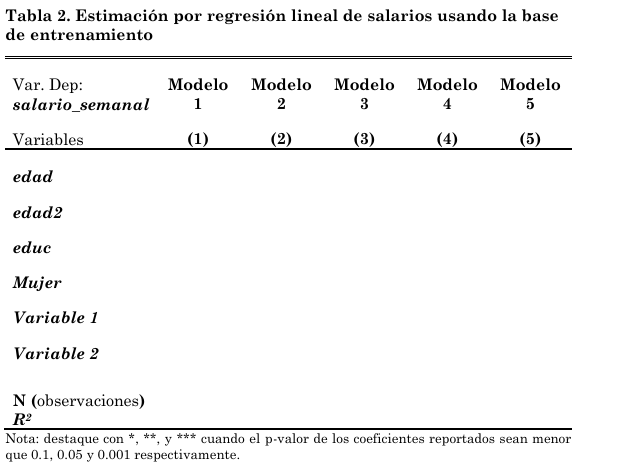

#3.
Enfoque de Validación: Ahora para cada modelo estime el salario
predicho de testeo (salario_semanal_test sombrerito) usando las
observaciones separadas de testeo y los coeficientes estimados en el
apartado anterior. Reporte y comente las siguientes métricas de testo
para cada modelo:

In [102]:
#MODELO 1
X1t = edad.loc[X_test.index]
y1t = salario_semanal.loc[y_test.index]

lreg = LinearRegression()

lreg.fit(X1t,y1t)
y1t_pred_lreg=lreg.predict(X1t)
ecm_lreg = mean_squared_error(y1t, y1t_pred_lreg)
rmse = np.sqrt(mean_squared_error(y1t, y1t_pred_lreg))
print('RMSE (test):', rmse)
mae = mean_absolute_error(y1t, y1t_pred_lreg)
print('MAE (test):', mae)
print('MSE (test):', ecm_lreg)


RMSE (test): 1271936.9382751521
MAE (test): 703918.7675682709
MSE (test): 1617823574948.7683


In [103]:
#MODELO 2
X2t = pd.concat([edad2.loc[X_test.index],
                edad.loc[X_test.index]], axis=1)
lreg.fit(X2t,y1t)
y1t_pred_lreg=lreg.predict(X2t)
ecm_lreg = mean_squared_error(y1t, y1t_pred_lreg)
rmse = np.sqrt(mean_squared_error(y1t, y1t_pred_lreg))
print('RMSE (test):', rmse)
mae = mean_absolute_error(y1t, y1t_pred_lreg)
print('MAE (test):', mae)
print('MSE (test):', ecm_lreg)

RMSE (test): 1226977.7378617402
MAE (test): 655910.0898199304
MSE (test): 1505474369208.313


In [104]:
#modelo 3
X3t = pd.concat([educ.loc[X_test.index],
                 edad2.loc[X_test.index],
                 edad.loc[X_test.index]], axis=1)

lreg.fit(X3t,y1t)
y1t_pred_lreg=lreg.predict(X3t)
ecm_lreg = mean_squared_error(y1t, y1t_pred_lreg)
rmse = np.sqrt(mean_squared_error(y1t, y1t_pred_lreg))
mae = mean_absolute_error(y1t, y1t_pred_lreg)
print('RMSE (test):', rmse)
print('MAE (test):', mae)
print('MSE (test):', ecm_lreg)

RMSE (test): 1225855.6443011954
MAE (test): 664552.1892692106
MSE (test): 1502722060665.0989


In [105]:
#modelo 4
X4t = pd.concat([ultimo_df['CH04'].loc[X_test.index].to_frame(),
                educ.loc[X_test.index],
                edad2.loc[X_test.index],
                edad.loc[X_test.index]],axis=1)

lreg.fit(X4t,y1t)
y1t_pred_lreg=lreg.predict(X4t)
ecm_lreg = mean_squared_error(y1t, y1t_pred_lreg)
rmse = np.sqrt(mean_squared_error(y1t, y1t_pred_lreg))
mae = mean_absolute_error(y1t, y1t_pred_lreg)
print('RMSE (test):', rmse)
print('MAE (test):', mae)
print('MSE (test):', ecm_lreg)

RMSE (test): 1222856.9389583776
MAE (test): 675634.2862115742
MSE (test): 1495379093158.6533


In [106]:
#MODELO 5
X5t = pd.concat([
    alfabeto.loc[X_test.index],
    estado_civil.loc[X_test.index],
    #Usamos.to_frame para poder meterlo en el index
    ultimo_df['CH04'].loc[X_test.index].to_frame(),
    educ.loc[X_test.index],
    edad2.loc[X_test.index],
    edad.loc[X_test.index]
], axis=1)

lreg.fit(X5t,y1t)
y1t_pred_lreg=lreg.predict(X5t)
ecm_lreg = mean_squared_error(y1t, y1t_pred_lreg)
rmse = np.sqrt(mean_squared_error(y1t, y1t_pred_lreg))
mae = mean_absolute_error(y1t, y1t_pred_lreg)
print('RMSE (test):', rmse)
print('MAE (test):', mae)
print('MSE (test):', ecm_lreg)

RMSE (test): 1219691.9271187722
MAE (test): 680804.337363534
MSE (test): 1487648397078.704


#4.
Opcional: Para el modelo de mejor performance, ilustre la predicción
de salarios (salario_semanal_hat_test) en un grafico de dispersión con
salario_semanal en el eje vertical y edad en el eje horizontal usando la
base de testeo. Comente brevemente el gráfico.


#C.
Métodos de Clasificación y Performance

#5.
Implementen los métodos de regresión logistica (logit) y vecinos
cercanos (KNN) con K=5 usando en la base de entrenamiento. Luego,
usando la base de testeo, reporte la matriz de confusión para p>0.5, la
curva ROC, los valores de AUC y de Accuracy de testeo de cada uno.
¿Cuál de los métodos predice mejor en cada año? Justifiquen
detalladamente utilizando las medidas de perfomance mencionadas
arribas.

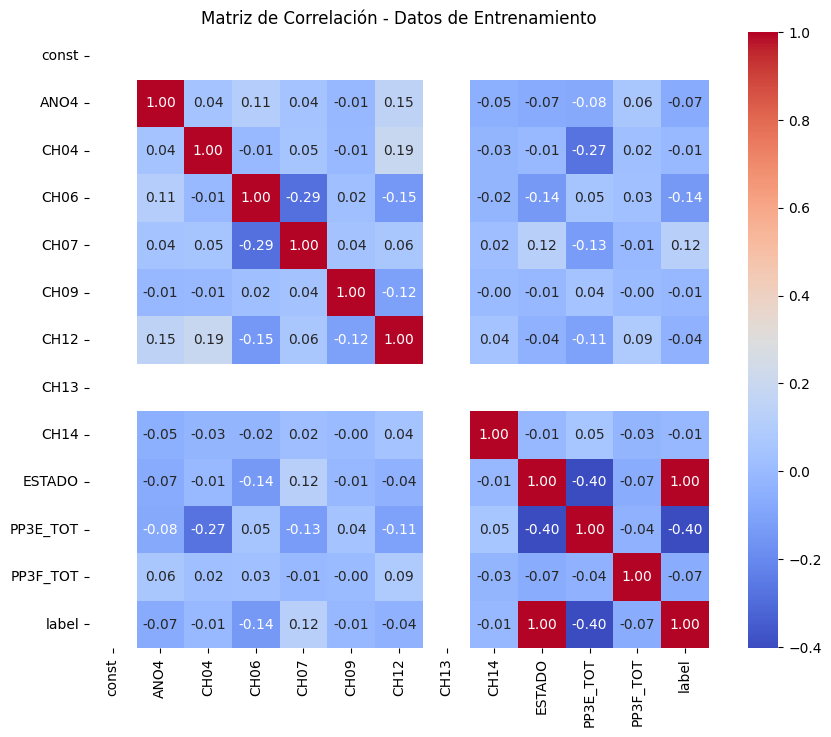

In [107]:
#Con esta matriz de correlacion hayamos la variable que nos daba problemas para la prediccion?
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación - Datos de Entrenamiento")
plt.show()

In [108]:
#Hacemos un segundo check para confirmar las sospechas aunque en la version final figura como false
print("Columnas en X:", X.columns)
print("'P21' en X", 'P21' in X.columns)

Columnas en X: Index(['ANO4', 'CH04', 'CH06', 'CH07', 'CH09', 'CH12', 'CH13', 'CH14',
       'ESTADO', 'PP3E_TOT', 'PP3F_TOT', 'label'],
      dtype='object')
'P21' en X False


In [109]:
#Aplicamos el metodo de regresion lineal
log_reg = LogisticRegression(penalty=None).fit(X_train, y_train)

#Tratamos de predecir p sombrero con nuestros datos
y_train_pred_score = log_reg.predict_proba(X_train)[:,1]
y_train_pred = log_reg.predict(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
print(X_train.shape)
print(y_train.shape)

(2432, 13)
(2432,)


In [111]:
#Miramos que tan cercano es nuestro modelo a el valor real
accuracy = accuracy_score(y_train, y_train_pred)
print('Accuracy Test: %f' % accuracy)

#Para hacer el recall usamos average por la cantidad de clases que tenemos, usamos macro para que calcule el recall para cada clase y lo promedie
recall = recall_score(y_train, y_train_pred, average='macro')
print('Recall Test: %f' % recall)

Accuracy Test: 0.129523
Recall Test: 0.006647


In [112]:
#Usamos vecinos cercanos con K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [113]:
#Predecimos con vecinos cercanos la exactitud de nuestro modelo
y_train_pred_knn = knn.predict(X_train)
accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print("La exactitud del modelo es: %.3f" %accuracy_knn)


La exactitud del modelo es: 0.342


In [114]:
#Aplico la regesion logisitica para el testeo
log_reg = LogisticRegression(penalty=None).fit(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
#Predecimos
y_test_pred = log_reg.predict(X_test)

In [116]:
#Hacemos la matriz de confusion
matriz_confusion=confusion_matrix(y_test, y_test_pred).ravel()
print('Matriz de confusion:')
print(matriz_confusion)
print('Accuracy Score:', accuracy_score(y_test, y_test_pred))

Matriz de confusion:
[29 12  0 ...  0  0  0]
Accuracy Score: 0.11505273250239693


In [117]:
# Para graficar la curva ROC lo mejor es usar la funcion LogisticRegression()
log_reg = LogisticRegression(penalty=None).fit(X_test.astype(float), y_test.astype(float))

# Estimacion de los coeficientes
print(log_reg.coef_)

# Predicciones (probabilidad) (p sobrerito)
y_test_pred_score = log_reg.predict_proba(X_test)
print(y_test_pred_score)

[[-7.34679986e-05  2.50276239e-04  2.25999694e-04 ... -5.76402877e-03
   5.43186523e-03 -7.63195317e-04]
 [ 5.60053926e-05  4.14580359e-03 -1.99956879e-03 ... -6.45147337e-02
  -1.19570133e-02  1.33673113e-02]
 [ 1.95442095e-06 -2.75420470e-04  2.09447795e-04 ... -9.97278996e-03
  -4.28162642e-04 -1.34735563e-05]
 ...
 [-1.60888769e-06 -5.58485353e-04  2.06353709e-04 ...  4.78325765e-03
  -4.31944109e-04 -1.62158127e-05]
 [-1.43105566e-06 -2.08648443e-04  2.04393585e-04 ... -1.21198559e-02
  -4.32305025e-04 -1.71892043e-05]
 [-1.61167767e-06 -5.68945620e-04  2.05650217e-04 ... -2.85213670e-04
  -4.32812165e-04 -1.64995411e-05]]
[[3.58525338e-02 1.36292234e-02 8.94167319e-04 ... 1.13147379e-03
  7.77461280e-04 1.03010141e-03]
 [9.24049395e-02 4.07956378e-02 1.39197436e-03 ... 1.03454867e-03
  1.18987285e-03 1.23306167e-03]
 [3.67883937e-02 3.16569787e-03 7.25400606e-04 ... 1.06676421e-03
  5.89197667e-04 9.61059495e-04]
 ...
 [1.36042683e-02 4.79377849e-01 7.39057341e-04 ... 4.45601913e

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
# Computamos la tasa de verdaderos positivos (tpr) y falsos positivos (tpr) para construir la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_score[:, 1], pos_label=2)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [120]:
#Calculamos el AUC
auc = roc_auc_score(y_test, y_test_pred_score,multi_class="ovr")
print('AUC: %.2f' % auc)

AUC: 0.81


#6.
Con el método que seleccionaron, predigan qué personas son
desocupadas dentro de la base norespondieron. ¿Qué proporción de
las personas que no respondieron pudieron identificar como
desocupadas?